# PyParticleBunch 

Testing of PyParticleBunch library

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
class Particle:
    def __init__(self, x, xp, y, yp, t, pt):
        self.__x = float(x)
        self.__xp = float(xp)
        self.__y = float(y)
        self.__yp = float(yp)
        self.__t = float(t)
        self.__pt = float(pt)
        
    @classmethod
    def fromfileline(cls, filename, n):        
        data = open(filename).readlines()
        data_line = data[n]
        input_coords = [x for x in data_line.split()]
        return cls(input_coords[0], input_coords[1], input_coords[2], input_coords[3], input_coords[4], input_coords[5])
    
    @classmethod
    def empty(cls):        
        return cls(0., 0., 0., 0., 0., 0.)
    
    def set_verbose(self): self.__verbose=True
        
    def get_coordinates(self):
        return np.array([self.__x, self.__xp, self.__y, self.__yp, self.__t, self.__pt])
    
    def get_x(self): return self.__x
    def get_xp(self): return self.__xp
    def get_y(self): return self.__y
    def get_yp(self): return self.__yp
    def get_t(self): return self.__t
    def get_pt(self): return self.__pt
    
    def set_x(self, x): self.__x = float(x)
    def set_xp(self, xp): self.__xp = float(xp)
    def set_y(self, y): self.__y = float(y)
    def set_yp(self, yp): self.__yp = float(yp)
    def set_t(self, t): self.__t = float(t)
    def set_pt(self, pt): self.__pt = float(pt)
        
    def MatrixMultiply(self, M):
        # Check Matrix is 6x6
        if M.shape == (6,6):
            p_i = np.array([self.__x,self.__xp,self.__y,self.__yp,self.__t,self.__pt])
            p_f = np.matmul(M, p_i)
            
            self.set_x(p_f[0])
            self.set_xp(p_f[1])
            self.set_y(p_f[2])
            self.set_yp(p_f[3])
            self.set_t(p_f[4])
            self.set_pt(p_f[5])
        else:
            print('Particle::MatrixMultiply: Matrix shape unexpected: ', M.shape)        
        
    def file_string(self):
        filestring = str(self.get_x())+ \
        '\t'+str(self.get_xp())+ \
        '\t'+str(self.get_y())+ \
        '\t'+str(self.get_yp())+ \
        '\t'+str(self.get_t())+ \
        '\t'+str(self.get_pt())+'\n'
        return filestring
    
    def MADX_string(self):
        MADX_filestring = 'start, x='+str(self.get_x())+ \
        ', px='+str(self.get_xp())+ \
        ', y='+str(self.get_y())+ \
        ', py='+str(self.get_yp())+ \
        ', t='+str(self.get_t())+ \
        ', pt='+str(self.get_pt())+';\n'
        return MADX_filestring
    
    def PTC_string(self):
        PTC_filestring = 'ptc_start, x='+str(self.get_x())+ \
        ', px='+str(self.get_xp())+ \
        ', y='+str(self.get_y())+ \
        ', py='+str(self.get_yp())+ \
        ', t='+str(self.get_t())+ \
        ', pt='+str(self.get_pt())+';\n'
        return PTC_filestring
        
    def add_to_file(self, filename):
        if os.path.isfile(filename):
            f = open(filename, 'a')
        else:
            f = open(filename, 'w')      
        f.write(self.file_string())
        f.close()
        
    def add_to_MADX_file(self, filename):
        if os.path.isfile(filename):
            f = open(filename, 'a')
        else:
            f = open(filename, 'w')        
        f.write(self.MADX_string())
        f.close()
        
    def add_to_PTC_file(self, filename):
        if os.path.isfile(filename):
            f = open(filename, 'a')
        else:
            f = open(filename, 'w')        
        f.write(self.PTC_string())
        f.close()
    

In [3]:
class MatchedBunchGenerator1D:
    
    def __init__(self, emittance, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.gamma = (1.0+self.alpha**2)/self.beta
        self.emittance = emittance
        self.dispersion_set = False
        self.__initialise()        
    
    def __initialise(self):
        self.u_max = math.sqrt(self.beta*self.emittance)
        self.up_coeff = math.sqrt(self.emittance/self.beta)
        self.up_max = math.sqrt(self.gamma*self.emittance)   
    
    # deltap = (Delta p)/p 
    def setDispersion(d, deltap):
        self.d = d
        self.deltap = deltap
        self.dispersion_set = True
    
    def setRMSEmittance(self, emittance):
        self.emittance = emittance
        self.__initialise()  
    
    def getRMSEmittance(self):
        return (self.emittance)
    
    def getUMax(self):return self.u_max
    def getUPMax(self):return self.up_max
    
    def NormaliseCoordinates(self, u_raw, up_raw):
        '''Returns normalised coordinate and momentum
        u = sqrt(beta*emittance)*u_raw
        up = sqrt(emittance/beta)*(up_raw-alpha*u_raw)'''
        u = self.u_max * u_raw
        up = self.up_coeff * (up_raw - self.alpha * u_raw)
        return (u,up)
    
    def KV_1D(self):
        # Double RMS emittance
        original_emittance = self.emittance
        self.setRMSEmittance(original_emittance*2)
        
        sign_choices = (-1.,1.)
        u_raw = math.sin(2*math.pi*(random.random()-0.5))
        up_raw = random.choice(sign_choices)*math.sqrt(1.0 - u_raw**2)
        
        self.setRMSEmittance(original_emittance)
        return self.NormaliseCoordinates(u_raw, up_raw)
    
    def KV_1D_array(self, n):
        array_u = []
        array_up = []
        
        for i in range(int(n)):
            u, up = self.KV_1D()            
            array_u.append(u)
            array_up.append(up)
        
        return (array_u, array_up)        
    
    def Waterbag_1D(self):
        # 4 x RMS emittance
        original_emittance = self.emittance
        self.setRMSEmittance(original_emittance*4)
        
        sign_choices = (-1.,1.)
        u_raw = math.sin(2*math.pi*(random.random()-0.5))
        up_raw = random.choice(sign_choices)*math.sqrt(1.0 - u_raw**2)
        
        r = math.sqrt(random.random())        
        u,up = self.NormaliseCoordinates(u_raw, up_raw)
        
        self.setRMSEmittance(original_emittance)
        return(r*u, r*up)
    
    def Waterbag_1D_array(self, n):
        array_u = []
        array_up = []
        
        for i in range(int(n)):
            u, up = self.Waterbag_1D()            
            array_u.append(u)
            array_up.append(up)
        
        return (array_u, array_up)   
    
    # Limit given in sigma
    def Gaussian_1D(self, limit):
        u_raw = random.gauss(0.,1.0)
        up_raw = random.gauss(0.,1.0)
        
        if(limit > 0.):
            while((u_raw**2+up_raw**2) > limit**2):                
                u_raw = random.gauss(0.,1.0)
                up_raw = random.gauss(0.,1.0)        
    
        return self.NormaliseCoordinates(u_raw, up_raw)
    
    def Gaussian_1D_array(self, n):
        array_u = []
        array_up = []
        
        for i in range(int(n)):
            u, up = self.Gaussian_1D()            
            array_u.append(u)
            array_up.append(up)
        
        return (array_u, array_up)   
    
    # Generates a particle in the u plane at 1 sigma
    def Poincare_1D(self): 
        if self.dispersion_set:
            u_raw = math.sqrt( self.beta*self.emittance + self.d**2 * (self.deltap)**2 )
            up_raw = 0.
        else:
            print('MatchedBunchGenerator1D::Poincare_1D: Dispersion Not Set - Assuming to be ZERO')        
            u_raw = math.sqrt( self.beta*self.emittance )
            up_raw = 0.
        return (u_raw, up_raw)
    
    def Poincare_1D_array(self, n, sig_min, sig_max):
        array_u = []
        array_up = []
        u, up = self.Poincare_1D()
        
        sig_range = sig_max - sig_min
        sig_step = sig_range / (n-1)
        
        for i in range(int(n)):          
            array_u.append(u*(i*sig_step+sig_min))
            array_up.append(up)
        
        return (array_u, array_up)   
        
        

In [4]:
class MatchedBunchGenerator2D:
    
    def __init__(self, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y):
        self.alpha_x = alpha_x
        self.alpha_y = alpha_y
        self.beta_y = beta_y
        self.beta_x = beta_x
        self.gamma_x = (1.0+self.alpha_x**2)/self.beta_x
        self.gamma_y = (1.0+self.alpha_y**2)/self.beta_y
        self.emittance_x = emittance_x
        self.emittance_y = emittance_y
        self.dispersion_set = False
        self.__initialise()        
    
    def __initialise(self):
        self.x_max = math.sqrt(self.beta_x*self.emittance_x)    
        self.y_max = math.sqrt(self.beta_y*self.emittance_y)
        self.xp_coeff = math.sqrt(self.emittance_x/self.beta_x) 
        self.yp_coeff = math.sqrt(self.emittance_y/self.beta_y)
        self.xp_max = math.sqrt(self.gamma_x*self.emittance_x)  
        self.yp_max = math.sqrt(self.gamma_y*self.emittance_y)   
        
        # deltap = (Delta p)/p 
    def setDispersion(dx, dy, deltap):
        self.dx = dx
        self.dy = dy
        self.deltap = deltap
        self.dispersion_set = True
        
    def setRMSEmittance(self, emittance_x, emittance_y):
        self.emittance_x = emittance_x
        self.emittance_y = emittance_y
        self.__initialise()  
            
    def getRMSEmittance(self):
        return (self.emittance_x, emittance_y)

    def getXMax(self):return self.x_max
    def getXPMax(self):return self.xp_max    
    def getYMax(self):return self.y_max
    def getYPMax(self):return self.yp_max
    
    def NormaliseCoordinates(self, x_raw, xp_raw, y_raw, yp_raw):
        '''Returns normalised coordinates and momenta
        u = sqrt(beta*emittance)*u_raw
        up = sqrt(emittance/beta)*(up_raw-alpha*u_raw)'''        
        x = self.x_max * x_raw
        xp = self.xp_coeff * (xp_raw - self.alpha_x * x_raw)
        y = self.y_max * y_raw
        yp = self.yp_coeff * (yp_raw - self.alpha_y * y_raw)    
        return (x,xp,y,yp)
   
    def KV_2D(self):
        # 4 x RMS emittance
        original_emittance_x = self.emittance_x
        original_emittance_y = self.emittance_y
        self.setRMSEmittance(original_emittance_x*4,original_emittance_y*4)
        
        #x-y plane
        phi = 2*math.pi*(random.random()-0.5)
        rho = math.sqrt(random.random())
        x_raw = rho*math.cos(phi)
        y_raw = rho*math.sin(phi)
        #momentum
        p0 = math.sqrt(math.fabs(1. - rho**2))
        phi = 2*math.pi*(random.random()-0.5)
        xp_raw = p0*math.cos(phi)
        yp_raw = p0*math.sin(phi)
        (x,xp,y,yp) = self.NormaliseCoordinates(x_raw,xp_raw,y_raw,yp_raw)
        
        self.setRMSEmittance(original_emittance_x,original_emittance_y)
        return (x,xp,y,yp)    
    
    def KV_2D_array(self, n):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        
        for i in range(int(n)):
            x, xp, y, yp = self.KV_2D()            
            array_x.append(x)
            array_xp.append(xp)
            array_y.append(y)
            array_yp.append(yp)
        
        return (array_x, array_xp, array_y, array_yp)   
    
    def Waterbag_2D(self):
        # 6 x RMS emittance
        original_emittance_x = self.emittance_x
        original_emittance_y = self.emittance_y
        self.setRMSEmittance(original_emittance_x*6,original_emittance_y*6)
          
        #x-y plane
        phi = 2*math.pi*(random.random()-0.5)
        rho = math.sqrt(random.random())
        x_raw = rho*math.cos(phi)
        y_raw = rho*math.sin(phi)
        #momentum
        p0 = math.sqrt(math.fabs(1. - rho**2))
        phi = 2*math.pi*(random.random()-0.5)
        xp_raw = p0*math.cos(phi)
        yp_raw = p0*math.sin(phi)
        
        (x,xp,y,yp) = self.NormaliseCoordinates(x_raw,xp_raw,y_raw,yp_raw)        
        r = math.sqrt(math.sqrt(random.random()))
        
        self.setRMSEmittance(original_emittance_x,original_emittance_y)
        return (x*r,xp*r,y*r,yp*r)   

    def Waterbag_2D_array(self, n):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        
        for i in range(int(n)):
            x, xp, y, yp = self.Waterbag_2D()            
            array_x.append(x)
            array_xp.append(xp)
            array_y.append(y)
            array_yp.append(yp)
        
        return (array_x, array_xp, array_y, array_yp)   
    
    # Limits given in sigma
    def Gaussian_2D(self, x_limit, y_limit):
        x_raw = random.gauss(0.,1.0)
        xp_raw = random.gauss(0.,1.0)        
        if(x_limit > 0.):
            while((x_raw**2+xp_raw**2) > x_limit**2):                
                x_raw = random.gauss(0.,1.0)
                xp_raw = random.gauss(0.,1.0) 
                
        y_raw = random.gauss(0.,1.0)
        yp_raw = random.gauss(0.,1.0)
        if(y_limit > 0.):
            while((y_raw**2+yp_raw**2) > y_limit**2):                
                y_raw = random.gauss(0.,1.0)
                yp_raw = random.gauss(0.,1.0)             
                
        return self.NormaliseCoordinates(x_raw,xp_raw,y_raw,yp_raw)
    
    def Gaussian_2D_array(self, x_limit, y_limit, n):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        
        for i in range(int(n)):
            x, xp, y, yp = self.Gaussian_2D(x_limit, y_limit)            
            array_x.append(x)
            array_xp.append(xp)
            array_y.append(y)
            array_yp.append(yp)
        
        return (array_x, array_xp, array_y, array_yp)      
    
        
    # Generates a particle in the u plane at 1 sigma in x AND y
    def Poincare_2D(self): 
        if self.dispersion_set:
            x_raw = math.sqrt( self.beta_x*self.emittance_x + self.dx**2 * (self.deltap)**2 )
            xp_raw = 0.
            y_raw = math.sqrt( self.beta_y*self.emittance_y + self.dy**2 * (self.deltap)**2 )
            yp_raw = 0.
        else:
            print('MatchedBunchGenerator1D::Poincare_1D: Dispersion Not Set - Assuming to be ZERO')        
            x_raw = math.sqrt( self.beta_x*self.emittance_x )
            xp_raw = 0.
            y_raw = math.sqrt( self.beta_y*self.emittance_y )
            yp_raw = 0.
        return (x_raw,xp_raw,y_raw,yp_raw)
    
    def Poincare_2D_array(self, n, sig_min, sig_max):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        
        x, xp, y, yp = self.Poincare_2D()
        
        sig_range = sig_max - sig_min
        sig_step = sig_range / (n-1)
        
        for i in range(int(n)):  
            array_x.append(x*(i*sig_step+sig_min))
            array_xp.append(xp)
            array_y.append(y*(i*sig_step+sig_min))
            array_yp.append(yp)
        
        return (array_x, array_xp, array_y, array_yp)      

In [5]:
class MatchedBunchGenerator3D:
    
    def __init__(self, emittance_x, emittance_y, emittance_z, alpha_x, beta_x, alpha_y, beta_y, alpha_z, beta_z):
        self.alpha_x = alpha_x
        self.alpha_y = alpha_y
        self.alpha_z = alpha_z
        self.beta_y = beta_y
        self.beta_x = beta_x
        self.beta_z = beta_z
        self.gamma_x = (1.0+self.alpha_x**2)/self.beta_x
        self.gamma_y = (1.0+self.alpha_y**2)/self.beta_y
        self.gamma_z = (1.0+self.alpha_z**2)/self.beta_z
        self.emittance_x = emittance_x
        self.emittance_y = emittance_y
        self.emittance_z = emittance_z
        self.dispersion_set = False
        self.__initialise()        
    
    def __initialise(self):
        self.x_max = math.sqrt(self.beta_x*self.emittance_x)    
        self.y_max = math.sqrt(self.beta_y*self.emittance_y)
        self.z_max = math.sqrt(self.beta_z*self.emittance_z)
        self.xp_coeff = math.sqrt(self.emittance_x/self.beta_x) 
        self.yp_coeff = math.sqrt(self.emittance_y/self.beta_y)
        self.zp_coeff = math.sqrt(self.emittance_z/self.beta_z)
        self.xp_max = math.sqrt(self.gamma_x*self.emittance_x)  
        self.yp_max = math.sqrt(self.gamma_y*self.emittance_y)   
        self.zp_max = math.sqrt(self.gamma_z*self.emittance_z)   
        
    # deltap = (Delta p)/p 
    def setDispersion(dx, dy, deltap):
        self.dx = dx
        self.dy = dy
        self.deltap = deltap
        self.dispersion_set = True
        
    def setRMSEmittance(self, emittance_x, emittance_y, emittance_z):
        self.emittance_x = emittance_x
        self.emittance_y = emittance_y        
        self.emittance_z = emittance_z
        self.__initialise()  
        
    def getRMSEmittance(self):
        return (self.emittance_x, emittance_y, emittance_z)

    def getXMax(self):return self.x_max
    def getXPMax(self):return self.xp_max    
    def getYMax(self):return self.y_max
    def getYPMax(self):return self.yp_max
    def getZMax(self):return self.z_max
    def getZPMax(self):return self.zp_max
    
    def NormaliseCoordinates(self, x_raw, xp_raw, y_raw, yp_raw, z_raw, zp_raw):
        '''Returns normalised coordinates and momenta
        u = sqrt(beta*emittance)*u_raw
        up = sqrt(emittance/beta)*(up_raw-alpha*u_raw)'''        
        x = self.x_max * x_raw
        xp = self.xp_coeff * (xp_raw - self.alpha_x * x_raw)
        y = self.y_max * y_raw
        yp = self.yp_coeff * (yp_raw - self.alpha_y * y_raw)    
        z = self.z_max * z_raw
        zp = self.zp_coeff * (zp_raw - self.alpha_z * z_raw)    
        return (x,xp,y,yp,z,zp)
    
    def KV_3D(self):
        # 6 x RMS emittance        
        original_emittance_x = self.emittance_x
        original_emittance_y = self.emittance_y
        original_emittance_z = self.emittance_z
        self.setRMSEmittance(original_emittance_x*6,original_emittance_y*6,original_emittance_z*6)
        
        #x-y-z-zp plane
        n_limit = 1000
        n_count = 0
        pxy2 = x_raw = y_raw = z_raw = zp_raw = 0.
        while(1 < 2):
            n_count = n_count + 1
            x_raw = 2*(random.random()-0.5)
            y_raw = 2*(random.random()-0.5)
            z_raw = 2*(random.random()-0.5)
            zp_raw = 2*(random.random()-0.5)
            pxy2 = 1.0 - x_raw**2 - y_raw**2 - z_raw**2 - zp_raw**2
            if(pxy2 > 0.):
                break
            if(n_count > n_limit):
                print("KV_3D: problem with Python random")
                print("Stop.")
                sys.exit(1)
                
        #make xp-yp plane
        pxy = math.sqrt(pxy2)
        phi = 2*math.pi*(random.random()-0.5)
        xp_raw = pxy*math.cos(phi)
        yp_raw = pxy*math.sin(phi)
        (x,xp,y,yp,z,zp) = self.NormaliseCoordinates(x_raw,xp_raw,y_raw,yp_raw,z_raw,zp_raw)
        
        self.setRMSEmittance(original_emittance_x,original_emittance_y,original_emittance_z)
        return (x,xp,y,yp,z,zp)   
    
    def KV_3D_array(self, n):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        array_z = []
        array_zp = []
        
        for i in range(int(n)):
            x, xp, y, yp, z, zp = self.KV_3D()            
            array_x.append(x)
            array_xp.append(xp)
            array_y.append(y)
            array_yp.append(yp)
            array_z.append(z)
            array_zp.append(zp)
        
        return (array_x, array_xp, array_y, array_yp, array_z, array_zp)
    
    def Waterbag_3D(self):
        # 8 x RMS emittance
        original_emittance_x = self.emittance_x
        original_emittance_y = self.emittance_y
        original_emittance_z = self.emittance_z
        self.setRMSEmittance(original_emittance_x*8,original_emittance_y*8,original_emittance_z*8)  
        
        #x-y-z-zp plane
        n_limit = 1000
        n_count = 0
        pxy2 = x_raw = y_raw = z_raw = zp_raw = 0.
        while(1 < 2):
            n_count = n_count + 1
            x_raw = 2*(random.random()-0.5)
            y_raw = 2*(random.random()-0.5)
            z_raw = 2*(random.random()-0.5)
            zp_raw = 2*(random.random()-0.5)
            pxy2 = 1.0 - x_raw**2 - y_raw**2 - z_raw**2 - zp_raw**2
            if(pxy2 > 0.):
                break
            if(n_count > n_limit):
                print("Waterbag_3D: problem with Python random")
                print("Stop.")
                sys.exit(1)
                
        #make xp-yp plane
        pxy = math.sqrt(pxy2)
        phi = 2*math.pi*(random.random()-0.5)
        xp_raw = pxy*math.cos(phi)
        yp_raw = pxy*math.sin(phi)
        (x,xp,y,yp,z,zp) = self.NormaliseCoordinates(x_raw,xp_raw,y_raw,yp_raw,z_raw,zp_raw)
        r = math.sqrt(math.sqrt(random.random()))
        
        self.setRMSEmittance(original_emittance_x,original_emittance_y,original_emittance_z)
        return (x*r,xp*r,y*r,yp*r,z*r,zp*r)         
    
    def Waterbag_3D_array(self, n):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        array_z = []
        array_zp = []
        
        for i in range(int(n)):
            x, xp, y, yp, z, zp = self.Waterbag_3D()            
            array_x.append(x)
            array_xp.append(xp)
            array_y.append(y)
            array_yp.append(yp)
            array_z.append(z)
            array_zp.append(zp)
        
        return (array_x, array_xp, array_y, array_yp, array_z, array_zp)
    
    # Limits given in sigma
    def Gaussian_3D(self, x_limit, y_limit, z_limit):
        x_raw = random.gauss(0.,1.0)
        xp_raw = random.gauss(0.,1.0)        
        if(x_limit > 0.):
            while((x_raw**2+xp_raw**2) > x_limit**2):                
                x_raw = random.gauss(0.,1.0)
                xp_raw = random.gauss(0.,1.0) 
                
        y_raw = random.gauss(0.,1.0)
        yp_raw = random.gauss(0.,1.0)
        if(y_limit > 0.):
            while((y_raw**2+yp_raw**2) > y_limit**2):                
                y_raw = random.gauss(0.,1.0)
                yp_raw = random.gauss(0.,1.0) 
                
        z_raw = random.gauss(0.,1.0)
        zp_raw = random.gauss(0.,1.0)
        if(z_limit > 0.):
            while((z_raw**2+zp_raw**2) > z_limit**2):                
                z_raw = random.gauss(0.,1.0)
                zp_raw = random.gauss(0.,1.0)    
                
        return self.NormaliseCoordinates(x_raw,xp_raw,y_raw,yp_raw,z_raw,zp_raw)
    
    def Gaussian_3D_array(self, x_limit, y_limit, z_limit, n):
        array_x = []
        array_xp = []
        array_y = []
        array_yp = []
        array_z = []
        array_zp = []
        
        for i in range(int(n)):
            x, xp, y, yp, z, zp = self.Gaussian_3D(x_limit, y_limit, z_limit)            
            array_x.append(x)
            array_xp.append(xp)
            array_y.append(y)
            array_yp.append(yp)
            array_z.append(z)
            array_zp.append(zp)
        
        return (array_x, array_xp, array_y, array_yp, array_z, array_zp)
     

In [6]:
class ParticleBunch:
    
    # Constructors
    #---------------------------------------------------------
        
    def __init__(self, n, ParticleArray):
        self.__n = int(n)
        self.__ParticleArray = ParticleArray           
            
    @classmethod
    def empty(cls, n):
        ParticleArray = np.empty([n], dtype=Particle)
        for i in range(n):
            ParticleArray[i] = Particle.empty()        
        return cls(n, ParticleArray)
    
    @classmethod
    def from_file(cls, filename, n=None):  
        if n is None:
            infile = open(filename)
            linelist = infile.readlines()
            file_len = len(linelist)
            n = file_len
            ParticleArray = np.empty([n], dtype=Particle)
            for i in range(file_len):
                ParticleArray[i] = Particle.fromfileline(filename,i)
        else:
            ParticleArray = np.empty([n], dtype=Particle)
            for i in range(n):
                ParticleArray[i] = Particle.fromfileline(filename,i)
        return cls(n, ParticleArray)
    
    # Populates the bunch as Gaussian in one plane, zeros in all other planes
    @classmethod
    def Gaussian_1D(cls, n, std_dev, mean, coordinate):  
        ParticleArray = np.empty([int(n)], dtype=Particle)
        coord = cls.sort_coordinate(coordinate)
        
        for i in range(int(n)):
            if coord == 'x':     ParticleArray[i] = Particle(cls.Gaussian_generator(mean, std_dev), 0., 0., 0., 0., 0.)
            elif coord == 'xp':  ParticleArray[i] = Particle(0., cls.Gaussian_generator(mean, std_dev), 0., 0., 0., 0.)
            elif coord == 'y':   ParticleArray[i] = Particle(0., 0., cls.Gaussian_generator(mean, std_dev), 0., 0., 0.)
            elif coord == 'yp':  ParticleArray[i] = Particle(0., 0., 0., cls.Gaussian_generator(mean, std_dev), 0., 0.)
            elif coord == 't':   ParticleArray[i] = Particle(0., 0., 0., 0., cls.Gaussian_generator(mean, std_dev), 0.)
            elif coord == 'pt':  ParticleArray[i] = Particle(0.,  0., 0., 0., 0., cls.Gaussian_generator(mean, std_dev))
        return cls(n, ParticleArray)
 
    # Populates the bunch as a 2D Gaussian in either x-xp, y-yp, or x-y phase space
    @classmethod
    def Gaussian_2D(cls, n, mean1, std_dev1, mean2, std_dev2, coordinate1, coordinate2):          
        ParticleArray = np.empty([int(n)], dtype=Particle)
        coord1 = cls.sort_coordinate(coordinate1)
        coord2 = cls.sort_coordinate(coordinate2)             
        
        random_coord_1_array = cls.Gaussian_array_generator(mean1, std_dev1, int(n))
        random_coord_2_array = cls.Gaussian_array_generator(mean2, std_dev2, int(n))
                
        for i in range(int(n)):        
            if coord1=='x' and coord2=='y':     
                ParticleArray[i] = Particle(random_coord_1_array[i], 0., random_coord_2_array[i], 0., 0., 0.)
            elif coord1=='y' and coord2=='x':   
                for i in range(int(n)):ParticleArray[i] = Particle(random_coord_2_array[i], 0., random_coord_1_array[i], 0., 0., 0.)
            elif coord1=='x' and coord2=='xp':  
                for i in range(int(n)):ParticleArray[i] = Particle(random_coord_1_array[i], random_coord_2_array[i], 0., 0., 0., 0.)                
            elif coord1=='xp' and coord2=='x':  
                for i in range(int(n)):ParticleArray[i] = Particle(random_coord_2_array[i], random_coord_1_array[i], 0., 0., 0., 0.)                
            elif coord1=='y' and coord2=='yp':  
                for i in range(int(n)):ParticleArray[i] = Particle(0., 0., random_coord_1_array[i], random_coord_2_array[i], 0., 0.)                
            elif coord1=='yp' and coord2=='y':  
                for i in range(int(n)):ParticleArray[i] = Particle(0., 0., random_coord_2_array[i], random_coord_1_array[i], 0., 0.)

        return cls(n, ParticleArray)
    
        # Populates the bunch as a 2D Gaussian in either x-xp, y-yp, or x-y phase space
    @classmethod
    def Gaussian_4D(cls, n, mean_x, std_dev_x, mean_xp, std_dev_xp, mean_y, std_dev_y, mean_yp, std_dev_yp):          
        ParticleArray = np.empty([int(n)], dtype=Particle)
                
        random_coord_x_array = cls.Gaussian_array_generator(mean_x, std_dev_x, int(n))
        random_coord_xp_array = cls.Gaussian_array_generator(mean_xp, std_dev_xp, int(n))
        random_coord_y_array = cls.Gaussian_array_generator(mean_y, std_dev_y, int(n))
        random_coord_yp_array = cls.Gaussian_array_generator(mean_yp, std_dev_yp, int(n))          
            
        for i in range(int(n)): ParticleArray[i] = Particle(random_coord_x_array[i], random_coord_xp_array[i], random_coord_y_array[i], random_coord_yp_array[i], 0., 0.)

        return cls(n, ParticleArray)
        
    @classmethod
    def MatchedGaussian_4D(cls, n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y, x_limit = 5, y_limit = 5):
        Generator = MatchedBunchGenerator2D(emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)
        array_x, array_xp, array_y, array_yp = Generator.Gaussian_2D_array(x_limit, y_limit, n)
        
        ParticleArray = np.empty([int(n)], dtype=Particle)
        for i in range(int(n)): ParticleArray[i] = Particle(array_x[i], array_xp[i], array_y[i], array_yp[i], 0., 0.)

        return cls(n, ParticleArray)

    @classmethod
    def MatchedKV_4D(cls, n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y):
        Generator = MatchedBunchGenerator2D(emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)
        array_x, array_xp, array_y, array_yp = Generator.KV_2D_array(n)
        
        ParticleArray = np.empty([int(n)], dtype=Particle)
        for i in range(int(n)): ParticleArray[i] = Particle(array_x[i], array_xp[i], array_y[i], array_yp[i], 0., 0.)

        return cls(n, ParticleArray)

    @classmethod
    def MatchedWaterbag_4D(cls, n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y):
        Generator = MatchedBunchGenerator2D(emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)
        array_x, array_xp, array_y, array_yp = Generator.Waterbag_2D_array(n)
        
        ParticleArray = np.empty([int(n)], dtype=Particle)
        for i in range(int(n)): ParticleArray[i] = Particle(array_x[i], array_xp[i], array_y[i], array_yp[i], 0., 0.)

        return cls(n, ParticleArray)
    
    @classmethod
    def Uniform_2D(cls, n, horizontal=True):  
        ParticleArray = np.empty([int(n)], dtype=Particle)
        if horizontal:
            for i in range(n):
                ParticleArray[i] = Particle(cls.Uniform_generator(), 0., 0., 0., 0., 0.)
        else:
            for i in range(n):
                ParticleArray[i] = Particle(0., 0., cls.Uniform_generator(), 0., 0., 0.)
        return cls(n, ParticleArray)

    @classmethod
    def Poincare_2D(cls, n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y, min_sig, max_sig, deltap=None, d_x=None, d_y=None):        
        Generator = MatchedBunchGenerator2D(emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)
        if (deltap is not None):
            if (d_x is not None):
                if (d_y is not None):
                    Generator.setDispersion(d_x, d_y, deltap)
                else:
                    Generator.setDispersion(d_x, 0., deltap)           
        
        array_x, array_xp, array_y, array_yp = Generator.Poincare_2D_array(n, min_sig, max_sig)

        ParticleArray = np.empty([int(n)], dtype=Particle)
        for i in range(int(n)): ParticleArray[i] = Particle(array_x[i], array_xp[i], array_y[i], array_yp[i], 0., 0.)

        return cls(n, ParticleArray)
    
    @classmethod
    def Poincare_1D(cls, n, coordinate, emittance, alpha, beta, min_sig, max_sig, deltap=None, dispersion=None):  
        coord = cls.sort_coordinate(coordinate)      
        Generator = MatchedBunchGenerator1D(emittance, alpha, beta)
        
        if coord == 'x':
            if (deltap is not None) and (dispersion is not None):
                    Generator.setDispersion(dispersion, 0., deltap)
            array_x, array_xp = Generator.Poincare_1D_array(n, min_sig, max_sig)
            for i in range(int(n)): ParticleArray[i] = Particle(array_x[i], array_xp[i], 0., 0., 0., 0.)

        elif coord == 'y':
            if (deltap is not None) and (dispersion is not None):
                    Generator.setDispersion(0., dispersion, deltap)
            array_y, array_yp = Generator.Poincare_1D_array(n, min_sig, max_sig)
            for i in range(int(n)): ParticleArray[i] = Particle(0., 0., array_y[i], array_yp[i], 0., 0.)
            
        else:
            print('ParticleBunch::Poincare_1D: coordinate must be x or y. Process abandoned')
            return False
        return cls(n, ParticleArray)    
    

    # Get and Set functions
    #---------------------------------------------------------
    def get_N(self): return self.__n
    
    def get_ParticleArray(self): return self.__ParticleArray
    
    def get_Particle(self,i): return self.__ParticleArray[i]
    
    def get_x_array(self):
        x_dat = np.empty(self.__n, dtype=float)
        i_x = 0
        for i in self:
            x_dat[i_x] = i.get_x()
            i_x +=1
        return x_dat
    
    def get_y_array(self):
        y_dat = np.empty(self.__n, dtype=float)
        i_y = 0
        for i in self:
            y_dat[i_y] = i.get_y()
            i_y +=1
        return y_dat
    
    def get_xp_array(self):
        xp_dat = np.empty(self.__n, dtype=float)
        i_xp = 0
        for i in self:
            xp_dat[i_xp] = i.get_xp()
            i_xp +=1
        return xp_dat
    
    def get_yp_array(self):
        yp_dat = np.empty(self.__n, dtype=float)
        i_yp = 0
        for i in self:
            yp_dat[i_yp] = i.get_yp()
            i_yp +=1
        return yp_dat
    
    def get_t_array(self):
        t_dat = np.empty(self.__n, dtype=float)
        i_t = 0
        for i in self:
            t_dat[i_t] = i.get_t()
            i_t +=1
        return t_dat
    
    def get_pt_array(self):
        pt_dat = np.empty(self.__n, dtype=float)
        i_pt = 0
        for i in self:
            pt_dat[i_pt] = i.get_pt()
            i_pt +=1
        return pt_dat      
    
    def get_coordinate_array(self, coordinate):
        coord = self.sort_coordinate(coordinate)
        
        if coord == 'x':     return self.get_x_array()       
        elif coord == 'xp':  return self.get_xp_array()
        elif coord == 'y':  return self.get_y_array()
        elif coord == 'yp':  return self.get_yp_array()
        elif coord == 't':  return self.get_t_array()
        elif coord == 'pt':  return self.get_pt_array()

    def print_MADX_file(self, filename):
        if os.path.isfile(filename): os.remove(filename)
        f = open(filename, 'w')   
        for i in self: f.write(i.MADX_string())
        f.close()
        
    def print_PTC_file(self, filename):
        if os.path.isfile(filename): os.remove(filename)
        f = open(filename, 'w')   
        for i in self: f.write(i.PTC_string())
        f.close()
        
    def print_file(self, filename):
        if os.path.isfile(filename): os.remove(filename)
        f = open(filename, 'w')   
        for i in self: f.write(i.file_string())
        f.close()

    def Gaussian_array_generator(mean, std_dev, n): 
        min_lim = -5*std_dev 
        max_lim = 5*std_dev   
        
        not_full = True
        num_array = []
        
        while not_full:   
            num = np.random.normal(mean, std_dev, size=None)
            if num <= max_lim and num >= min_lim: num_array.append(num)                
            if len(num_array) >= n: not_full=False

        return num_array
    
    def Gaussian_generator(mean, std_dev): 
        min_lim = -5*std_dev 
        max_lim = 5*std_dev   
            
        within_limits = True
        while within_limits:
            n = np.random.normal(mean, std_dev, size=None)
            if n <= max_lim and n >= min_lim: within_limits = False
        return n
    
    def Uniform_generator():
        min_lim = 0.0 
        max_lim = 1.0   
            
        within_limits = True
        while within_limits:
            n = np.random.uniform(0,1, size=None)
            if n <= max_lim and n >= min_lim: within_limits = False
        return n        
            
    # Users may use uppercase or lowercase char/strings, or numbers to identify the co-ordinate
    def sort_coordinate(self, coordinate):        
        if coordinate == 'x' or coordinate == 'X' or coordinate == 1 or coordinate == '1':
            return 'x'
        elif coordinate == 'xp' or coordinate == 'XP' or coordinate == 'x\'' or coordinate == 'X\'' or coordinate == 2 or coordinate == '2':
            return 'xp'
        elif coordinate == 'y' or coordinate == 'Y' or coordinate == 3 or coordinate == '3':
            return 'y' 
        elif coordinate == 'yp' or coordinate == 'YP' or coordinate == 'y\'' or coordinate == 'Y\'' or coordinate == 4 or coordinate == '4':
            return 'yp'
        elif coordinate == 't' or coordinate == 'T' or coordinate == 'z' or coordinate == 'Z' or coordinate == 5 or coordinate == '5':
            return 't'        
        elif coordinate == 'pt' or coordinate == 'PT' or coordinate == 'E' or coordinate == 'dE' or coordinate == 6 or coordinate == '6':
            return 'pt'        
        else:
            print('ParticleBunch::sort_coordinate:ERROR\tco-ordinate ',str(coordinate),' not recognised')
            return False
    
    # MATCHING
    #---------------------------------------------
    def Beta_Matrix(self, beta_x, beta_y): 
        return np.array([[np.sqrt(beta_x),0,0,0,0,0],
             [0,(1/np.sqrt(beta_x)),0,0,0,0],
             [0,0,np.sqrt(beta_y),0,0,0],
             [0,0,0,(1/np.sqrt(beta_y)),0,0],
             [0,0,0,0,1,0],
             [0,0,0,0,0,1]])

    def Alpha_Matrix(self, alpha_x, alpha_y): 
        return np.array([[1,0,0,0,0,0],
             [-alpha_x,1,0,0,0,0],
             [0,0,1,0,0,0],
             [0,0,-alpha_y,1,0,0],
             [0,0,0,0,1,0],
             [0,0,0,0,0,1]])    

    def Delta_Matrix(self, D_x, D_y, D_xp, D_yp): 
        return np.array([[1,0,0,0,0,0],
             [0,1,0,0,0,0],
             [0,0,1,0,0,0],
             [0,0,0,1,0,0],
             [0,0,0,0,1,0],
             [D_x, D_xp, D_y, D_yp,0,1]])

    def Matching_Matrix(self, beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp):
        A = self.Alpha_Matrix(alpha_x, alpha_y)
        B = self.Beta_Matrix(beta_x, beta_y)
        D = self.Delta_Matrix(D_x, D_y, D_xp, D_yp)

        # Matrix multiplication is associative (AB)C = A(BC)
        C = np.matmul(D, B)
        return np.matmul(C, A)
    
    def Match(self, beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp):    
        MM6 = self.Matching_Matrix(beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp)
        for i in self: i.MatrixMultiply(MM6)
    
    # ITERATORS
    #---------------------------------------------
    def __iter__(self):
        self.__iter_n = 0
        return self
        
    def __next__(self):
        if self.__iter_n <= self.__n-1:
            result = self.__ParticleArray[self.__iter_n]
            self.__iter_n += 1
            return result         
        else:
            raise StopIteration            
            
    # PLOTTING
    #---------------------------------------------
    def plot_heatmap(self, coordinate1, coordinate2, savefile, bins=128):    
        coord1 = self.sort_coordinate(coordinate1)
        coord2 = self.sort_coordinate(coordinate2)      
        u_dat = self.get_coordinate_array(coord1)
        v_dat = self.get_coordinate_array(coord2)
        
        u_max = v_max = u_min = v_min = 0.           
        if np.max(u_dat) > u_max : u_max = np.max(u_dat)*1.05
        if np.max(v_dat) > v_max : v_max = np.max(v_dat)*1.05 
        if np.min(u_dat) < u_min : u_min = np.min(u_dat)*1.05             
        if np.min(v_dat) < v_min : v_min = np.min(v_dat)*1.05 
            
        plt.rcParams['font.size'] = 6
        plt.rcParams['legend.fontsize'] = 'large'
        plt.rcParams['legend.handlelength'] = 5
        plt.rcParams['lines.linewidth'] = 0.5
        plt.rcParams['lines.markersize'] = 0.25
        fig = plt.figure(figsize=[4.0, 4.0], dpi=200, facecolor='white', edgecolor='k')        
        gridspec.GridSpec(3,3) # Create grid to resize subplots        
        fig.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
        fig.subplots_adjust(wspace = 0) # Vertical spacing between subplots

        title = 'Gaussian x-xp phase space'

        # 2D Histogram
        plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
        plt.hist2d(u_dat, v_dat, bins, range=[[u_min, u_max],[v_min, v_max]])
        
        if coord1 == 'x':    u_label = 'x [m]'
        elif coord1 == 'xp': u_label = 'xp [-]'
        elif coord1 == 'y': u_label = 'y [m]'
        elif coord1 == 'yp': u_label = 'yp [-]'
        elif coord1 == 't': u_label = 't [m]'
        elif coord1 == 'pt': u_label = 'pt [-]'
        if coord2 == 'x':    v_label = 'x [m]'
        elif coord2 == 'xp': v_label = 'xp [-]'
        elif coord2 == 'y': v_label = 'y [m]'
        elif coord2 == 'yp': v_label = 'yp [-]'
        elif coord2 == 't': v_label = 't [m]'
        elif coord2 == 'pt': v_label = 'pt [-]'      
        plt.xlabel(u_label)
        plt.ylabel(v_label)
        
        axis_main = plt.gca()
        axis_main_ylim = axis_main.axes.get_ylim()
        axis_main_xlim = axis_main.axes.get_xlim()
        
        plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
        plt.hist(u_dat, bins = bins,  range = [u_min, u_max], density=False)
        plt.grid(which='both', ls=':', lw=0.5)
        plt.ylabel('Frequency')
        axis_top = plt.gca()
        axis_top.axes.set_xlim(axis_main_xlim)
        axis_top.xaxis.set_ticks_position("top")
        plt.title(title)

        plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
        plt.hist(v_dat, bins = bins,  range = [v_min, v_max], density=False, orientation=u'horizontal')
        plt.grid(which='both', ls=':', lw=0.5)
        plt.xlabel('Frequency')
        axis_right = plt.gca()
        axis_right.axes.set_ylim(axis_main_ylim)
        axis_right.yaxis.set_ticks_position("right")

        if savefile is None: savefile = 'ParticleBunch_Heatmap_'+coord1+'_'+coord2+'.png'
        fig.savefig(savefile, bbox_inches='tight');

        
        

# Test methods of bunch generation 

In [7]:
beta_x = 3.215250830692
beta_y = 18.598794417925
alpha_x =  -0.547366008626
alpha_y =  2.750780302852
D_x =  -0.000103040524
D_xp = 0.001254020379
D_y = 0.
D_yp = 0.
emittance_x = emittance_y = 400 * 1E-6 * np.pi
x_limit = 5
y_limit = 5
n = 1E6

In [8]:
myMatchedGaussianBunch = ParticleBunch.MatchedGaussian_4D(n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y, x_limit = 5, y_limit = 5)

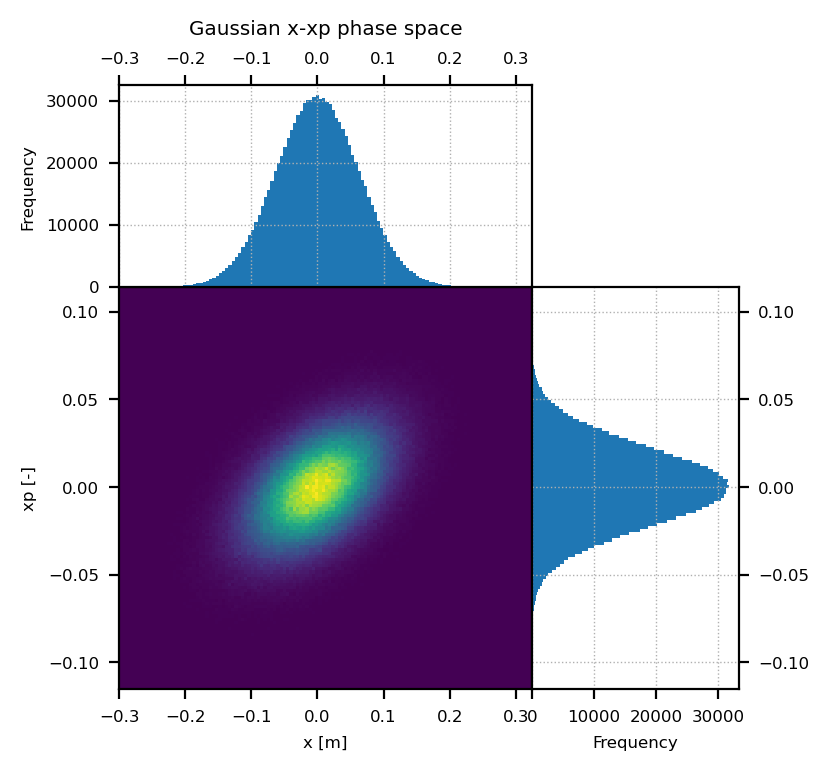

In [9]:
myMatchedGaussianBunch.plot_heatmap('x', 'xp', 'Gaussian_horizontal.png')

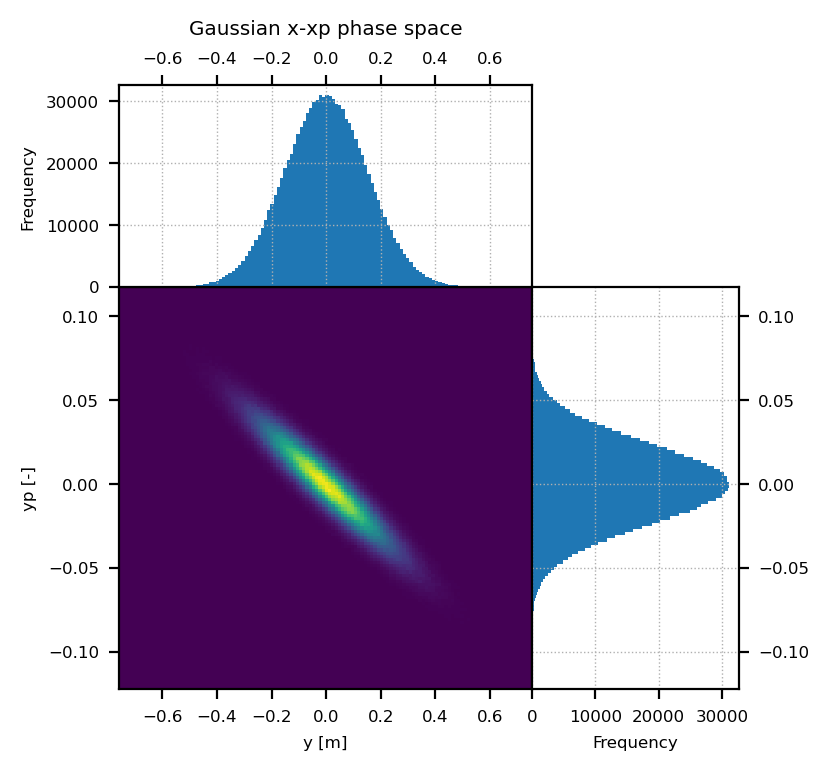

In [10]:
myMatchedGaussianBunch.plot_heatmap('y', 'yp', 'Gaussian_vertical.png')

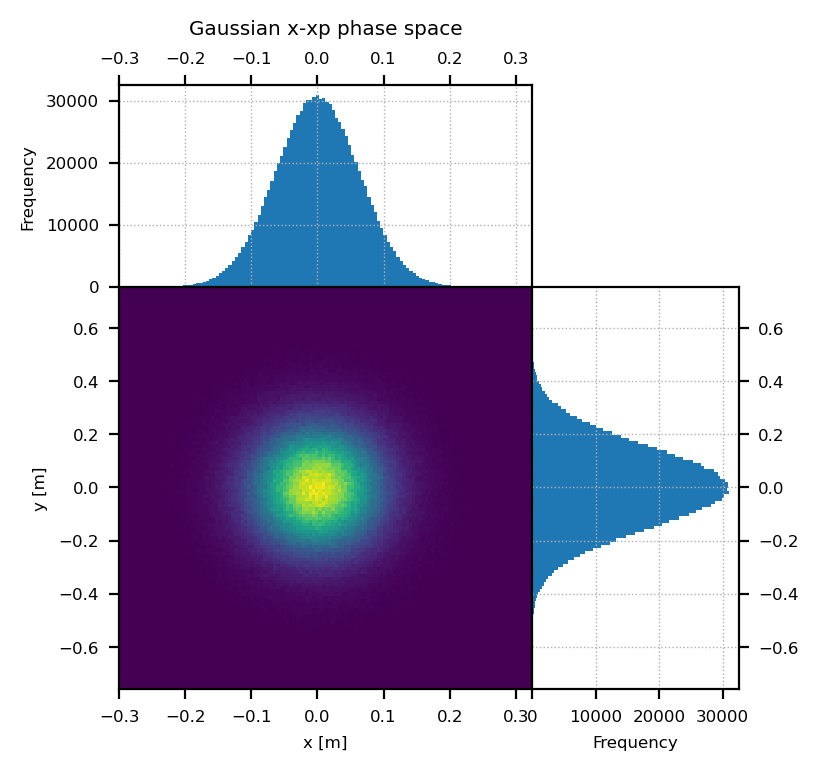

In [11]:
myMatchedGaussianBunch.plot_heatmap('x', 'y', 'Gaussian_real.png')

In [12]:
myMatchedWaterbagBunch = ParticleBunch.MatchedWaterbag_4D(n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)

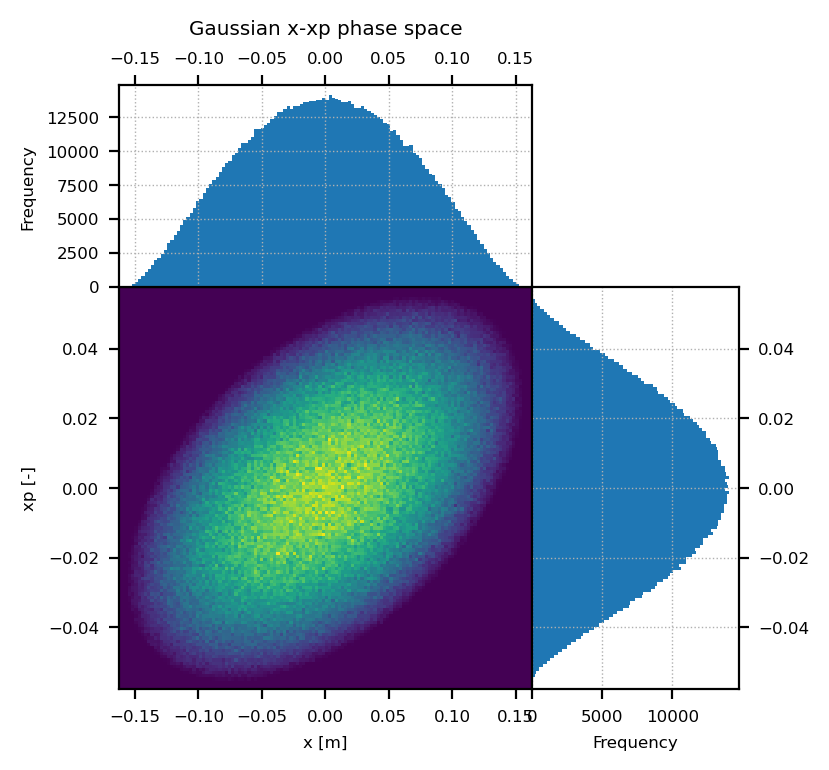

In [13]:
myMatchedWaterbagBunch.plot_heatmap('x', 'xp', 'Waterbag_horizontal.png')

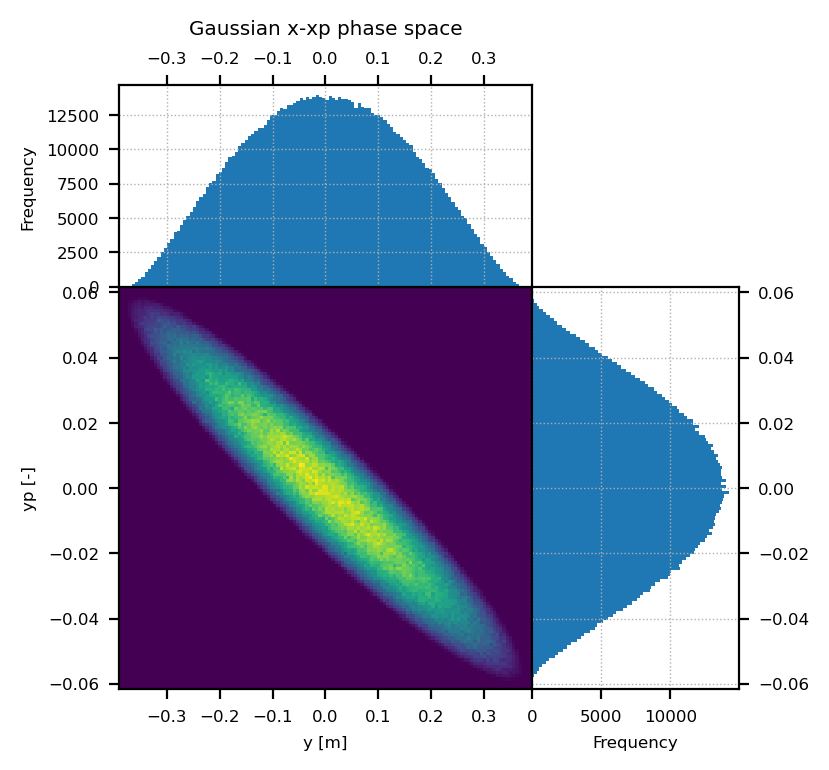

In [14]:
myMatchedWaterbagBunch.plot_heatmap('y', 'yp', 'Waterbag_vertical.png')

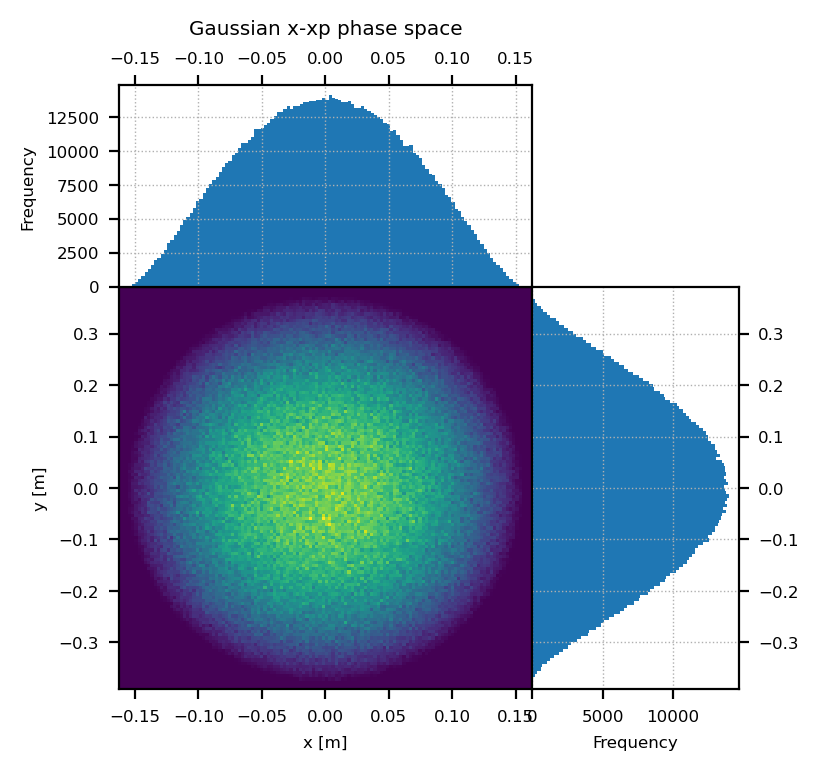

In [15]:
myMatchedWaterbagBunch.plot_heatmap('x', 'y', 'Waterbag_real.png')

In [16]:
myMatchedKVBunch = ParticleBunch.MatchedKV_4D(n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)

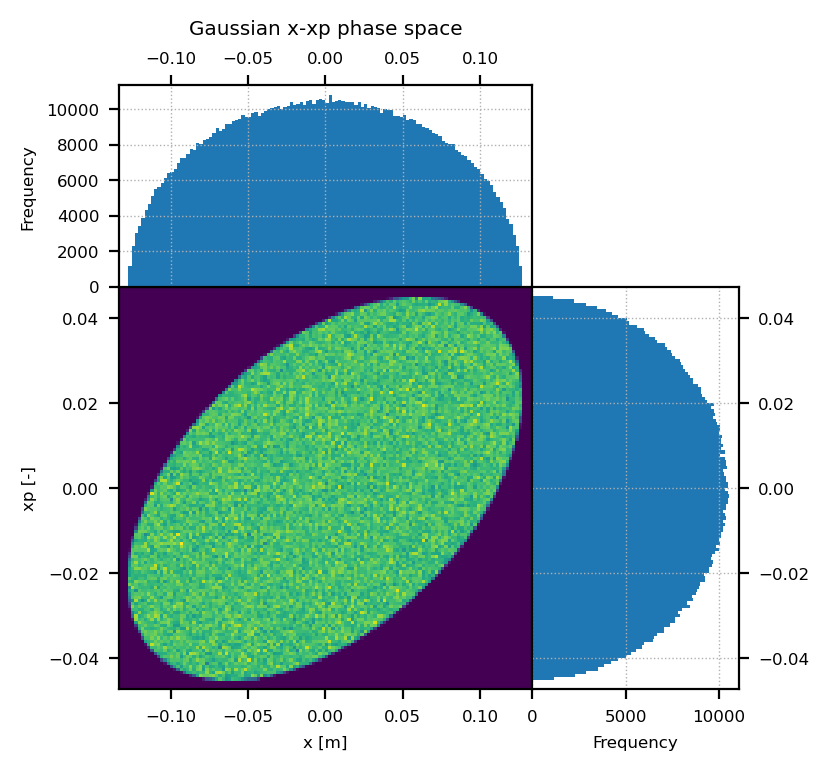

In [17]:
myMatchedKVBunch.plot_heatmap('x', 'xp', 'KV_horizontal.png')

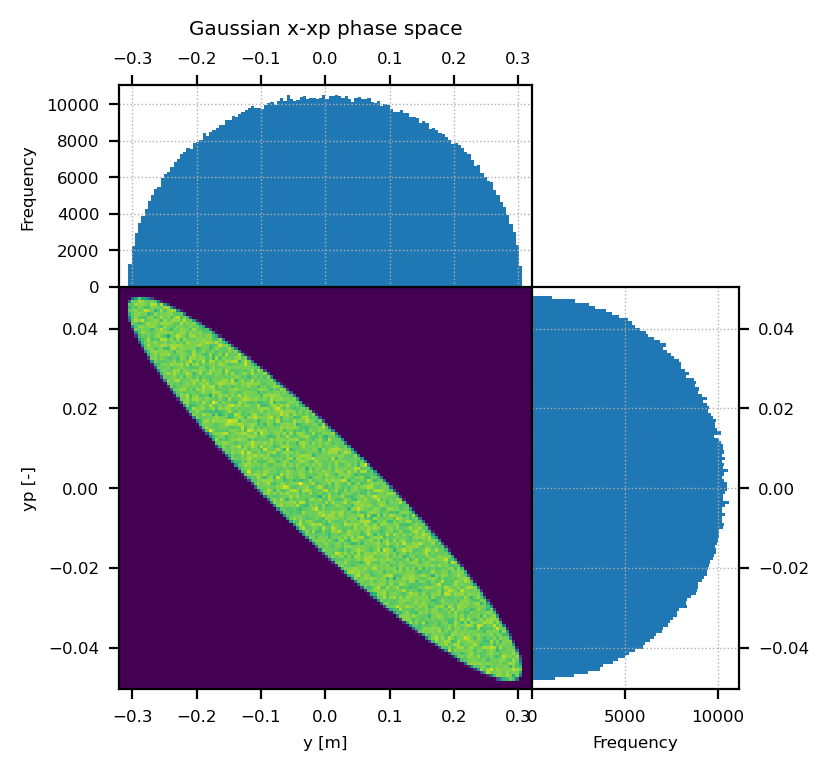

In [18]:
myMatchedKVBunch.plot_heatmap('y', 'yp', 'KV_vertical.png')

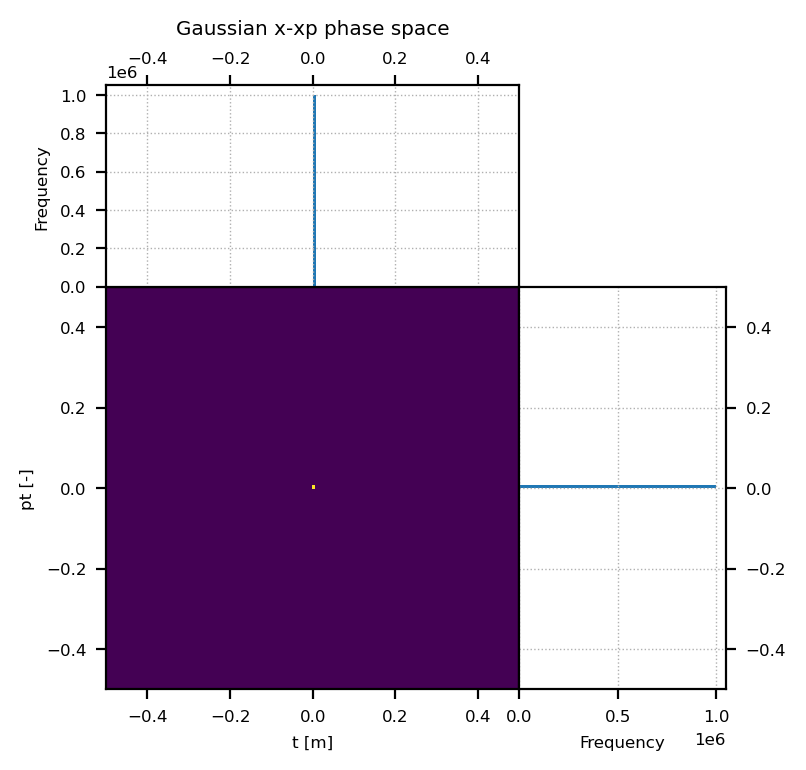

In [19]:
myMatchedKVBunch.plot_heatmap('t', 'pt', 'KV_longitudinal.png')

In [20]:
myMatchedKVBunch.print_MADX_file('ISIS_II_Start_KV_400pi.dat')

# ISIS-II Existing Hall RCS Extraction 

In [21]:
beta_x = 3.183218456327231
beta_y = 17.366440445018583
alpha_x =  -0.002213666757314968
alpha_y =  -0.0010751726719423877
D_x =  0.0003478381975430389
D_xp = -0.0010490010818251987
D_y = 0.
D_yp = 0.
emittance_x = emittance_y = 750 * 1E-6 * np.pi
x_limit = 5
y_limit = 5
n = 1E5

In [22]:
ISIS_II_EH_RCS_GaussianBunch = ParticleBunch.MatchedGaussian_4D(n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y, x_limit = 5, y_limit = 5)

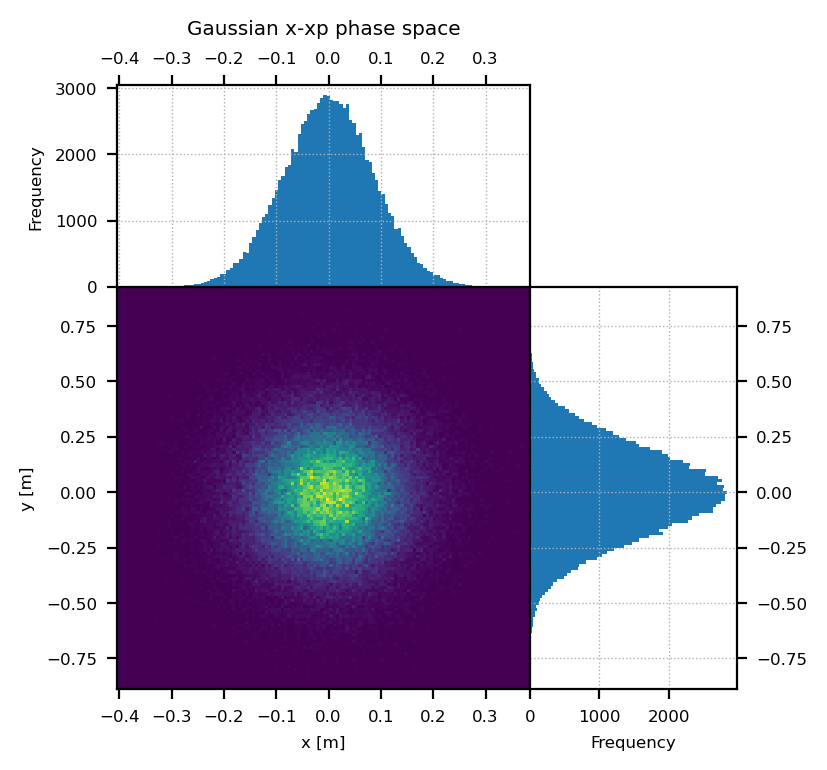

In [23]:
ISIS_II_EH_RCS_GaussianBunch.plot_heatmap('x', 'y', 'ISIS_II_IH_RCS_Gaussian_real.png')

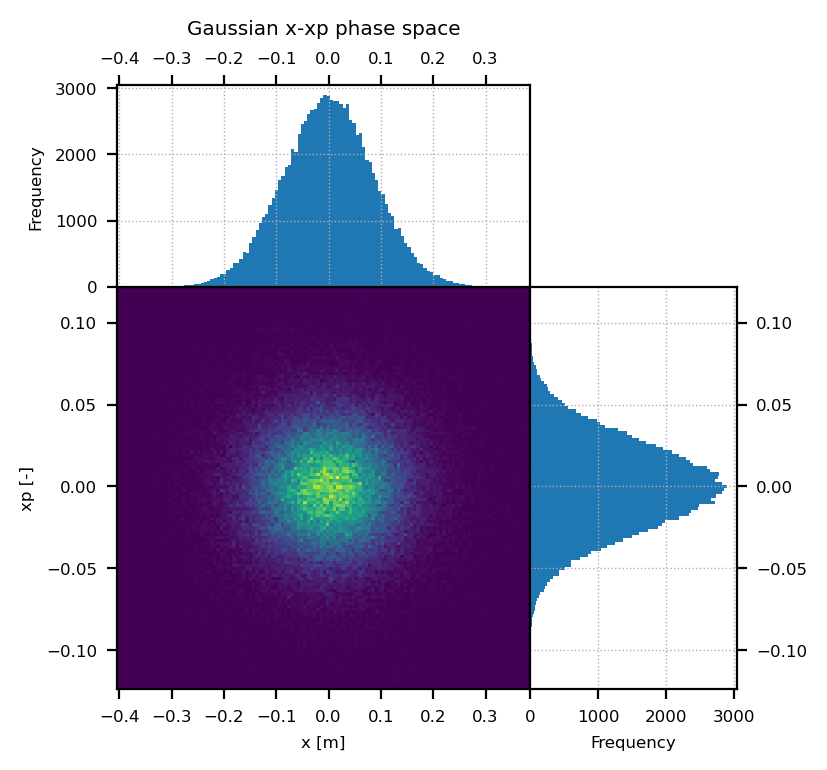

In [24]:
ISIS_II_EH_RCS_GaussianBunch.plot_heatmap('x', 'xp', 'ISIS_II_IH_RCS_Gaussian_horizontal.png')

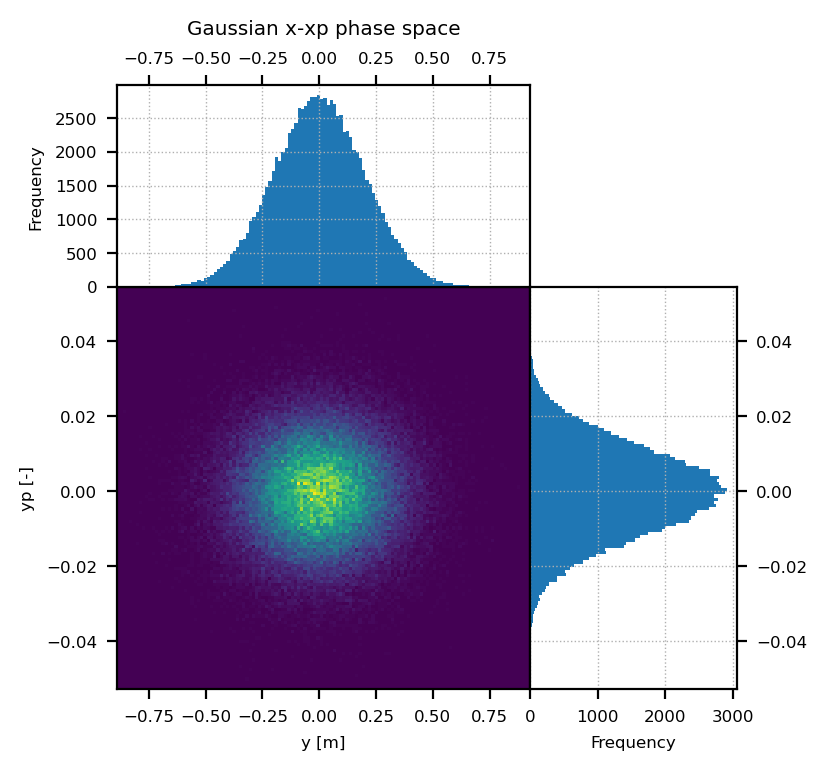

In [25]:
ISIS_II_EH_RCS_GaussianBunch.plot_heatmap('y', 'yp', 'ISIS_II_IH_RCS_Gaussian_vertical.png')

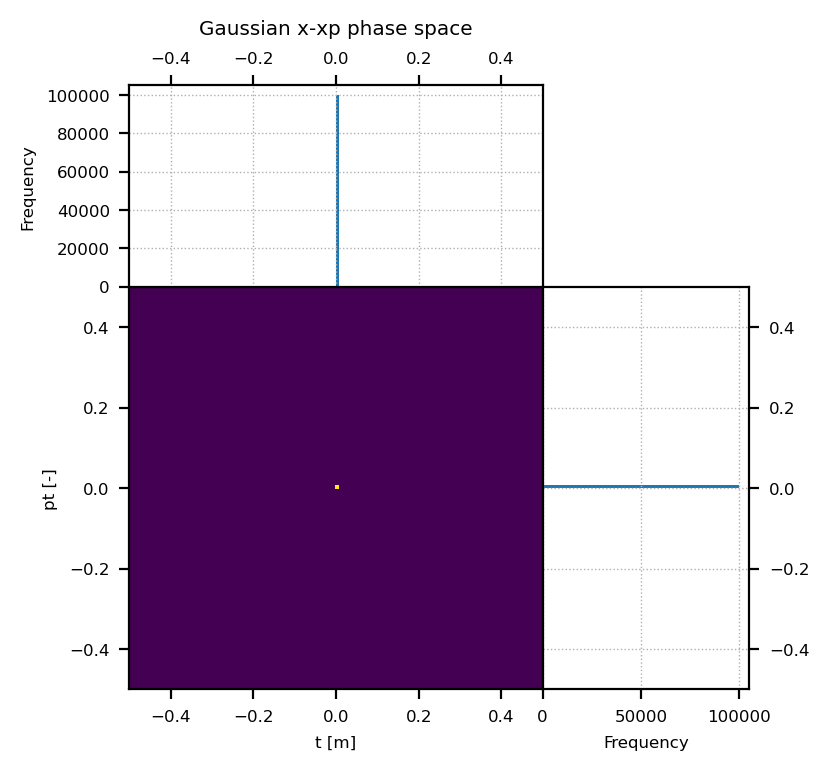

In [26]:
ISIS_II_EH_RCS_GaussianBunch.plot_heatmap('t', 'pt', 'ISIS_II_IH_RCS_Gaussian_longitudinal.png')

In [27]:
ISIS_II_EH_RCS_GaussianBunch.print_MADX_file('ISIS_II_Extraction_Gaussian_750pi_1E5.dat')

In [28]:
ISIS_II_EH_RCS_GaussianBunch.print_PTC_file('ISIS_II_Extraction_Gaussian_750pi_1E5.ptc')

# Test Poincare 

In [29]:
PoincareGenerator = MatchedBunchGenerator1D(emittance_x, alpha_x, beta_x)

In [30]:
min_sig = 0
max_sig = 5
n_mp = 10
Poincare_x, Poincare_xp = PoincareGenerator.Poincare_1D_array(n_mp, min_sig, max_sig)

MatchedBunchGenerator1D::Poincare_1D: Dispersion Not Set - Assuming to be ZERO


In [31]:
Poincare_x

[0.0,
 0.04811342625901558,
 0.09622685251803116,
 0.14434027877704672,
 0.19245370503606232,
 0.24056713129507787,
 0.28868055755409344,
 0.33679398381310904,
 0.38490741007212464,
 0.4330208363311402]

In [32]:
sig_step = (max_sig - min_sig)/(n_mp-1)
sig_step*=math.sqrt(beta_x*emittance_x)
sig_step

0.04811342625901558

In [33]:
sig_min = min_sig * math.sqrt(beta_x*emittance_x)
sig_min

0.0

In [34]:
sig_min+sig_step

0.04811342625901558

In [35]:
sig_min+sig_step+sig_step

0.09622685251803116

In [36]:
sig_min+sig_step+sig_step+sig_step

0.14434027877704675

In [37]:
sig_min+sig_step+sig_step+sig_step+sig_step

0.19245370503606232

In [38]:
sig_max = max_sig * math.sqrt(beta_x*emittance_x)
sig_max

0.4330208363311402

In [39]:
sig_max-sig_step

0.3849074100721246

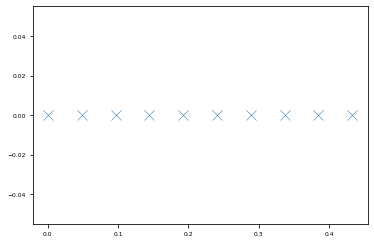

In [40]:
plt.scatter(Poincare_x, Poincare_xp, s=100, marker='x')

In [41]:
PoincareGenerator2D = MatchedBunchGenerator2D(emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y)

In [42]:
min_sig = 0
max_sig = 5
n_mp = 10
Poincare_x, Poincare_xp, Poincare_y, Poincare_yp = PoincareGenerator2D.Poincare_2D_array(n_mp, min_sig, max_sig)

MatchedBunchGenerator1D::Poincare_1D: Dispersion Not Set - Assuming to be ZERO


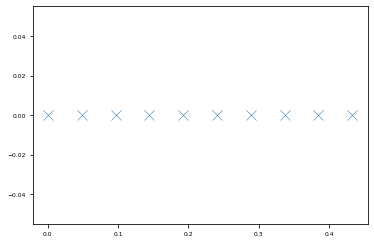

In [43]:
plt.scatter(Poincare_x, Poincare_xp, s=100, marker='x')

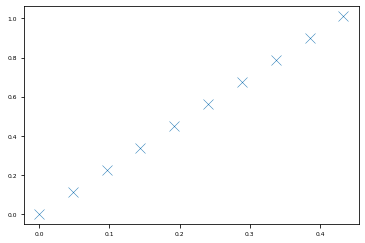

In [44]:
plt.scatter(Poincare_x, Poincare_y, s=100, marker='x')

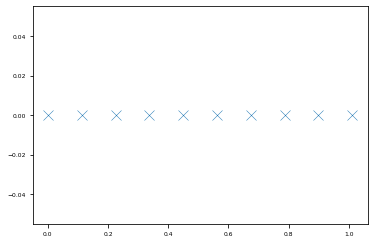

In [45]:
plt.scatter(Poincare_y, Poincare_yp, s=100, marker='x')

In [46]:
beta_x = 3.183218456327231
beta_y = 17.366440445018583
alpha_x =  -0.002213666757314968
alpha_y =  -0.0010751726719423877
D_x =  0.0003478381975430389
D_xp = -0.0010490010818251987
D_y = 0.
D_yp = 0.
emittance_x = emittance_y = 750 * 1E-6 * np.pi
min_sig = 0
max_sig = 10
n = 10
ISIS_II_EH_RCS_PoincareBunch = ParticleBunch.Poincare_2D(n, emittance_x, emittance_y, alpha_x, beta_x, alpha_y, beta_y, min_sig, max_sig)      

MatchedBunchGenerator1D::Poincare_1D: Dispersion Not Set - Assuming to be ZERO


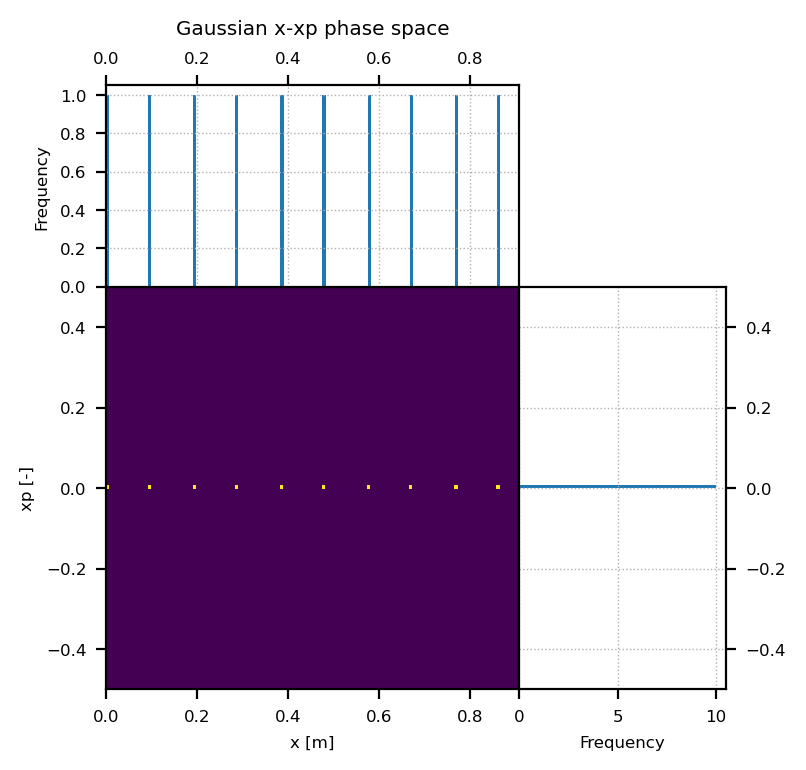

In [47]:
ISIS_II_EH_RCS_PoincareBunch.plot_heatmap('x', 'xp', 'ISIS_II_IH_RCS_Poincare_horizontal.png')

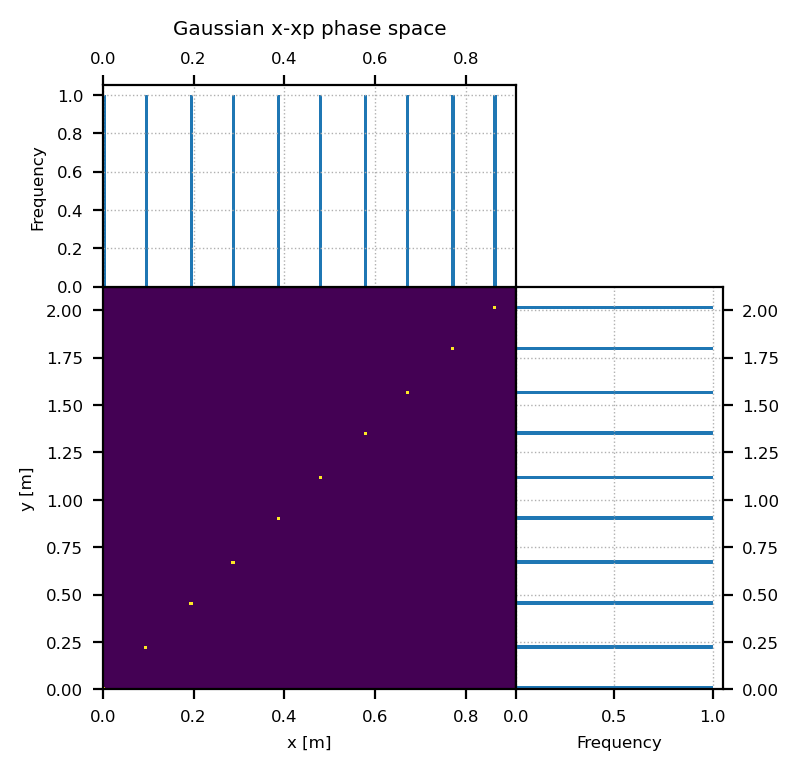

In [48]:
ISIS_II_EH_RCS_PoincareBunch.plot_heatmap('x', 'y', 'ISIS_II_IH_RCS_Poincare_real.png')